In [1]:
%load_ext pycodestyle_magic

In [2]:
%flake8_on

# PROJET 5 : Catégorisation automatiquement des questions

## SOMMAIRE  <a class="anchor" id="sommaire"></a>
## [CONTEXTE DU PROJET](#1)<a class="anchor" id="sommaire"></a>
## [IMPORT DES LIBRAIRIES](#3)<a class="anchor" id="sommaire"></a>

## [MISSION 3: PREPROCESSING](#11)<a class="anchor" id="sommaire"></a>
### [M3-1 : Préparation des input et output : ](#12)<a class="anchor" id="sommaire"></a>
### [M3-2 : Séparation de jeu de données de test et d'entrainement : ](#13)<a class="anchor" id="sommaire"></a>

## [MISSION 4: APPROCHE NON-SUPERVISEE](#15)<a class="anchor" id="sommaire"></a>
### [M4-1 : Modélisation avec algorithme LDA : ](#16)<a class="anchor" id="sommaire"></a>
### [M5-1 : Modélisation avec algorithme NMF : ](#17)<a class="anchor" id="sommaire"></a>

## [MISSION 5: APPROCHE SUPERVISEE](#20)<a class="anchor" id="sommaire"></a>


--------------------------------------------------------

## [CONTEXTE DU PROJET](#sommaire)<a class="anchor" id="1"></a>

Stack Overflow est un site de questions-réponses liées au développement informatique.
Les tags nous permettent de retrouver facilement la réponse à une question posée, pourtant ce n'est pas évident de trouver des tags associés à notre question.
Donc il était intéressant de développer un application qui suggererait automatiquement plusieurs tags pertinents à partir d'une question posée. 

## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="3"></a>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import nltk
import os
import re
import warnings
import pyLDAvis.gensim
import pickle
import requests
import json
from time import time
from utils.functions import custom_tokenize, print_top_words
from utils.functions import predictTag, vectorizeInputTest
from utils.functions import remove_stopword, cleanText, pattern_searcher
from utils.functions import compute_coherence_values, print_topics
from nltk.stem import WordNetLemmatizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from sklearn.decomposition import NMF
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, jaccard_score
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.dummy import DummyClassifier

In [7]:
# Configuration affichage
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## [MISSION 3: PREPROCESSING](#sommaire)<a class="anchor" id="11"></a>

#### Récuperation des données texte :

Exportons les données stockées dans des fichiers texte :

- data/tags_words_tokens.csv : contient les données de base
- data/Backup/top1000_words.csv : contient les données de top 1000 des mots 
- data/Backup/top100_tags.csv : contient les données de top 100 des tags
- data/Backup/X_data.csv
- data/Backup/y_data.csv

In [8]:
data_preprocess = pd.read_csv('data/Backup/tags_words_tokens.csv',
                              sep='\t', engine='python')
data_preprocess.drop(['Unnamed: 0'], axis=1, inplace=True)

top1000words_exp = pd.read_csv('data/Backup/top1000_words.csv',
                               header=None, index_col=0,
                               squeeze=True).to_dict()
top100tags_exp = pd.read_csv('data/Backup/top100_tags.csv',
                             header=None, index_col=0,
                             squeeze=True).to_dict()

### [M3-1 : Préparation des input et output : ](#sommaire)<a class="anchor" id="12"></a>

#### vectorisation de corpus par Bag Of Words:

In [10]:
# Corpus (=X) en entrée on aura un ensmble de mots -> Body + Title
X_data = pd.read_csv('data/Backup/X_data.csv', sep='\t', engine='python')
X_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [11]:
# X_data

#### vectorisation des tags par MultiLabelBinarizer :

In [12]:
# 4.1 Tags (=y)
y_data = pd.read_csv('data/Backup/y_data.csv', sep='\t', engine='python')
y_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [13]:
# y_data

Le resultat est une matrice de (8292, 100) car nous avons 8292 lignes et 100 (tags) nouvelles colonnes.

### [M3-2 : Séparation de jeu de données de test et d'entrainement : ](#sommaire)<a class="anchor" id="13"></a>

Nous allons utiliser 80% des données pour l'entrainement et 20% pour le test

In [14]:
# Split train and test :
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1)

## [MISSION 4: APPROCHE NON-SUPERVISEE](#sommaire)<a class="anchor" id="15"></a>

In [15]:
n_samples = 0.8
n_features = 1000
n_components = 20
n_top_words = 10
data_preprocess_copy = cleanText(data_preprocess)
data_preprocess_copy.drop(['tokens', 'tokensStopWord'], axis=1, inplace=True)
corpus = data_preprocess_copy['words_tokens']
tags = data_preprocess_copy['tags_tokens']
datasetX = corpus.tolist()
datasety = tags.tolist()

X_trainBis = datasetX[:int(len(datasetX)*n_samples)]
y_trainBis = datasety[:int(len(datasety)*n_samples)]
X_testBis = datasetX[int(len(datasetX)*n_samples):]
y_testBis = datasety[int(len(datasety)*n_samples):]


def dummy(doc):
    return doc

### [M4-1 : Modélisation avec algorithme LDA : ](#sommaire)<a class="anchor" id="16"></a>

LDA (Latent Dirichlet Allocation) est un modèle probabiliste génératif avec les hypothèses suivantes : 

•	Chaque question du corpus est un ensemble de mots sans ordre (bag-of-words) ;

•	Chaque question m aborde un certain nombre de topic dans différentes proportions qui lui sont propres p(θm) ;

•	Chaque mot possède une distribution associée à chaque topic p(ϕk) . On peut ainsi représenter chaque topic par une 
probabilité sur chaque mot.

•	 zn représente le topic du mot wn


In [16]:
print("Vectorisation et entrainement du modèle pour LDA...")

tfidf_vectorizer_lda = CountVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       tokenizer=dummy, preprocessor=dummy,
                                       analyzer='word')
tfidf_lda = tfidf_vectorizer_lda.fit_transform(X_trainBis)


Vectorisation et entrainement du modèle pour LDA...


#### La recherche de nombre de topics optimal avec HDP models:

In [17]:
from gensim.models import HdpModel
dictionary = Dictionary(datasetX)
train_id2word = Dictionary(corpus)
corpus_copy = corpus.copy()
train_corpus = [dictionary.doc2bow(doc) for doc in corpus_copy]
hdp = HdpModel(train_corpus, train_id2word, chunksize=10000)
nbrOPticOptim = len(hdp.print_topics())
print('Le nombre de topics optimal :', nbrOPticOptim)

Le nombre de topics optimal : 20


In [18]:
# entrainer le modèle :
n_topics = 20
n_top_words = 10

lda = LDA(n_components=nbrOPticOptim, n_jobs=-1)
lda.fit(tfidf_lda)

print("\nLes topics du modele LDA :")
tf_feature_names = tfidf_vectorizer_lda.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

# hdp.print_topics(num_topics=20)


Les topics du modele LDA :
Topic #0: exception thread code ball way lock method would style throw
Topic #1: c++ book programming good language question code feature linux java
Topic #2: error sql procedure join currency stored view query index object
Topic #3: application user web java using best server service request would
Topic #4: string java code use new object question like linq using
Topic #5: content foo loop header internet want explorer using input line
Topic #6: javascript function text jquery using html like way page element
Topic #7: git branch merge commit repository svn change master remote like
Topic #8: div number std container range element parent sequence map code
Topic #9: file script command window code directory line way source like
Topic #10: string int value javascript url jquery character option http way
Topic #11: database date server using sql memory time mysql get set
Topic #12: class pattern image use static method one view design java
Topic #13: use varia

In [19]:
# Representation graphique des 20 topics :
# pyLDAvis nous permet de visualiser les résultats de LDA interractif.

from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
LDAvis_prepared = sklearn_lda.prepare(lda, tfidf_lda,
                                      tfidf_vectorizer_lda, R=n_top_words)
pyLDAvis.display(LDAvis_prepared)

Sur le côté gauche, la zone de chaque cercle représente l'importance du topic par rapport au corpus. 

Comme il y a 20 topics, nous avons 20 cercles.
La distance entre le centre des cercles indique la similitude entre les sujets. 
Ici, les topics qui se chevauchentont donc des sujets plus similaires.

Sur le côté droit, l' histogramme de chaque topic montre les 10 mots les plus pertinents . 
Par exemple, dans le topic 1, les mots les plus pertinents sont file, use, object, like, ...

In [20]:
# Sauvegarder le modèle sur le disque :
pickle.dump(lda, open('models/lda.pkl', 'wb'))
pickle.dump(corpus_copy, open('models/corpus_copy.pkl', 'wb'))
pickle.dump(train_id2word, open('models/train_id2word.pkl', 'wb'))

#### Générer les tags à partir de LDA

In [21]:
from utils.functions import remove_stopword
def recommend_tags(text, model, n_topics, n_top_words, X_train):
    ''' Recomendation system for stackoverflow posts based on a lda model,
    it returns up to n_topics tags.
    Parameters:
    text: the stackoverflow post of user
    data_train: data to fit the model with
    '''
    threshold = 0.011
    list_scores = []
    list_words = []
    used = set()

    # vectoriser les données en entrée
    data = {'BodyTitle':  text, 'Tags': ['']}
    dfInput = pd.DataFrame(data, columns=['BodyTitle', 'Tags'])
    dataInput = cleanText(dfInput)
    corpusInputlist = dataInput['words_tokens'].tolist()

    tfidfVectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                      max_features=n_features,
                                      tokenizer=dummy,
                                      preprocessor=dummy)
    tfidfVectorizer.fit_transform(X_train)
    text_tfidf = tfidfVectorizer.transform(corpusInputlist)
    text_projection = model.transform(text_tfidf)
    feature_names = tfidfVectorizer.get_feature_names()
    # utiliser les modeles LDA-NMF pour extraire les scores de chaque mot-tags
    components = model.components_/model.components_.sum(axis=1)[:, np.newaxis]
    for topic in range(n_topics):
        topic_score = text_projection[0][topic]

        for (word_idx, word_score) in zip(components[topic].argsort()
                                          [:-n_top_words - 1:-1],
                                          sorted(components[topic])
                                          [:-n_top_words - 1:-1]):
            score = topic_score*word_score

            if score >= threshold:
                list_scores.append(score)
                list_words.append(feature_names[word_idx])
                used.add(feature_names[word_idx])

    results = [tag for (y, tag) in sorted(zip(list_scores, list_words),
                                          key=lambda pair: pair[0],
                                          reverse=True)]
    tags = ", ".join(filter(None, results[:10]))
    # tokenizé les tags pour calculer la performance di=u modele
    tags_tokens = custom_tokenize(tags)
    tags_tokens2 = remove_stopword(tags_tokens)
    return tags_tokens2

2:1: E302 expected 2 blank lines, found 0


In [22]:
data_preprocess_predict_lda = data_preprocess.copy()
print("generer les tags pour LDA...")
t0 = time()
list_predicted_lda = [recommend_tags(text, lda, n_topics,
                                     n_top_words,
                                     X_trainBis) for text in data_preprocess_predict_lda['BodyTitle']]
data_preprocess_predict_lda['tags_predicted_lda'] = list_predicted_lda
print("fait en %0.3fs." % (time() - t0))
data_preprocess_predict_lda.head(5)

generer les tags pour LDA...
fait en 223.299s.


,Id,BodyTitle,words_tokens,tags_tokens,tags_predicted_lda
0,9,"in c#, how do i calculate someones age based o...","['calculate', 'someone', 'age', 'based', 'date...","['c', '.net', 'datetime']","[database, date, server, using, sql, memory, t..."
1,11,calculate relative time in c# given a specific...,"['calculate', 'relative', 'time', 'given', 'sp...","['c', 'datetime', 'time', 'datediff', 'relativ...","[database, list, date, server, using, sql]"
2,13,determine a users timezone is there a standard...,"['determine', 'user', 'timezone', 'standard', ...","['html', 'browser', 'timezone', 'user-agent', ...","[application, user]"
3,42,best way to allow plugins for a php applicatio...,"['best', 'way', 'allow', 'plugins', 'php', 'ap...","['php', 'plugins', 'architecture', 'hook']","[difference, object]"
4,173,versioning sql server database i want to get m...,"['versioning', 'sql', 'server', 'database', 'w...","['sql-server', 'database', 'svn', 'version-con...","[list, python, module, array]"


6:80: E501 line too long (102 > 79 characters)


### [M5-1 : Modélisation avec algorithme NMF : ](#sommaire)<a class="anchor" id="17"></a>

**NMF**(Non-Negative Matrix Factorization)est aussi une technique non supervisée,C'est une alyernative au LDA

In [23]:
# Use tf-idf features for NMF.
print("Extraction des features pour NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   tokenizer=dummy,
                                   preprocessor=dummy)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(X_trainBis)
tfidf_test = tfidf_vectorizer.transform(X_testBis)
print("fait en %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fit de modele NMF (Frobenius norm) avec tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("fait en %0.3fs." % (time() - t0))

print("\nLes Topics dans NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Extraction des features pour NMF...
fait en 0.120s.
Fit de modele NMF (Frobenius norm) avec tf-idf features, n_samples=0 and n_features=1000...
fait en 0.426s.

Les Topics dans NMF model (Frobenius norm):
Topic #0: code use would like way using one ive know application
Topic #1: file directory line open path header batch xml using filename
Topic #2: string convert like way comparison int char character str remove
Topic #3: table database sql mysql column server row name select query
Topic #4: git branch commit repository merge svn change remote add conflict
Topic #5: function return var call jquery variable something parameter way int
Topic #6: difference whats one i++ use vs. main performance loop explain
Topic #7: python module print directory source using window platform output use
Topic #8: class method static public private interface abstract void use object
Topic #9: list item generic use order range name person search linked
Topic #10: div image jquery element img center id= htm

Sur les differents topics résultants de NMF ici, on peut facilement deduire visuellement par exemple que :
 - le topic 2 parle de gestion de versionning de projet
 - le topic 5 parle de base des données

#### Générer les tags à partir de NMF

In [24]:
data_preprocess_predict_lda_nmf = data_preprocess_predict_lda.copy()
print("generer les tags pour NMF...")
t0 = time()
list_predicted_nmf = [recommend_tags(text, nmf, n_topics,
                                     n_top_words,
                                     X_trainBis) for text in data_preprocess_predict_lda_nmf['BodyTitle']]
data_preprocess_predict_lda_nmf['tags_predicted_nmf'] = list_predicted_nmf
print("fait en %0.3fs." % (time() - t0))
data_preprocess_predict_lda_nmf.head(5)

generer les tags pour NMF...
fait en 262.659s.


,Id,BodyTitle,words_tokens,tags_tokens,tags_predicted_lda,tags_predicted_nmf
0,9,"in c#, how do i calculate someones age based o...","['calculate', 'someone', 'age', 'based', 'date...","['c', '.net', 'datetime']","[database, date, server, using, sql, memory, t...",[date]
1,11,calculate relative time in c# given a specific...,"['calculate', 'relative', 'time', 'given', 'sp...","['c', 'datetime', 'time', 'datediff', 'relativ...","[database, list, date, server, using, sql]","[date, value]"
2,13,determine a users timezone is there a standard...,"['determine', 'user', 'timezone', 'standard', ...","['html', 'browser', 'timezone', 'user-agent', ...","[application, user]",[string]
3,42,best way to allow plugins for a php applicatio...,"['best', 'way', 'allow', 'plugins', 'php', 'ap...","['php', 'plugins', 'architecture', 'hook']","[difference, object]",[]
4,173,versioning sql server database i want to get m...,"['versioning', 'sql', 'server', 'database', 'w...","['sql-server', 'database', 'svn', 'version-con...","[list, python, module, array]","[test, table]"


6:80: E501 line too long (106 > 79 characters)


### Calcul des scores de performances pour LDA et NMF :

Pour mesurer la similarité entre la prédiction des modèles et les vrais tags, nous allons utiliser la jaccard_similarity_score, elle permet de quantifier leur ressemblance (vecteurs des tags de prédictions et vecteurs des vrais tags)

La cosine_simularity est une valeur comprise dans l'intervalle [-1,1], 

 - -1 indiquera des vecteurs opposés, 
 
 - 0 des vecteurs indépendants  

 - 1 des vecteurs similaires 

In [25]:
# 4.1 Tags de prédiction LDA (=y)
tags_LDA = data_preprocess_predict_lda_nmf['tags_predicted_lda']
mlb2 = MultiLabelBinarizer()
tags_LDA_vect = pd.DataFrame(mlb2.fit_transform(tags_LDA),
                             columns=mlb2.classes_)

# 4.1 Tags de prédiction NMF (=y)
tags_NMF = data_preprocess_predict_lda_nmf['tags_predicted_nmf']
mlb3 = MultiLabelBinarizer()
tags_NMF_vect = pd.DataFrame(mlb3.fit_transform(tags_NMF),
                             columns=mlb3.classes_)

tags_Real_vect = y_data

In [26]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return float(len(s1.intersection(s2))) / float(len(s1.union(s2)))

In [27]:
jacard_score_LDA = jaccard_similarity(tags_Real_vect, tags_LDA_vect)
jacard_score_NMF = jaccard_similarity(tags_Real_vect, tags_NMF_vect)
print('Jacard similarity LDA : ', jacard_score_LDA)
print('Jacard similarity NMF : ', jacard_score_NMF)

Jacard similarity LDA :  0.13106796116504854
Jacard similarity NMF :  0.1619718309859155


Donc nous constatons que les scores des cosine_simularity sont supérieurs au DummyClassifier mais ils sont très proche de 0 
Donc les vecteurs sont independants, il faudra tester d'autres approche de prédiction

## [MISSION 5: APPROCHE SUPERVISEE](#sommaire)<a class="anchor" id="20"></a>

Certains modèles ne peuvent pas faire de la prediction pour une sortie comprenant plusieurs output. 
Il faut donc utiliser le MulitOutputClassifier

MulitOutputClassifier

Tester plusieurs modèles : LogistiRegression, SGDClassifier, MultinomialDB, LearSVC, Perceptron, PassiveAggressiveClassifier, RandomForest, KNN
    
Comparer : utiliser le Jaccard score et l'accuracy    

In [29]:
# to ignore ConvergenceWarning
warnings.filterwarnings("ignore")

#### Knn model :

In [30]:
print("Training a KNN Model...")
t0 = time()
knn_clf = KNeighborsClassifier()
knn_clf_fit = MultiOutputClassifier(knn_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a KNN Model...
fait en 39.420s.


In [31]:
y_pred_knn = knn_clf_fit.predict(X_test)
accuracy_score_knn = accuracy_score(y_test, y_pred_knn)
jaccard_score_knn = jaccard_score(y_test, y_pred_knn, average='samples')
print(accuracy_score_knn, jaccard_score_knn)

0.09501187648456057 0.06441013460015835


#### SGDClassifier

In [32]:
print("Training a SGDClassifier Model...")
t0 = time()
sgd_linear_clf = SGDClassifier(random_state=1, max_iter=5, tol=1e-3)
sgd_linear_clf_fit = MultiOutputClassifier(sgd_linear_clf).fit(X_train,
                                                               y_train)
print("fait en %0.3fs." % (time() - t0))

Training a SGDClassifier Model...
fait en 3.670s.


In [33]:
y_pred_sgd = sgd_linear_clf_fit.predict(X_test)
accuracy_score_sgd = accuracy_score(y_test, y_pred_sgd)
jaccard_score_sgd = jaccard_score(y_test, y_pred_sgd, average='samples')
print(accuracy_score_sgd, jaccard_score_sgd)

0.2042755344418052 0.3637032009953625


#### RandomForest 

In [34]:
print("Training a Random Forest Model...")
t0 = time()
rand_for_clf = RandomForestClassifier(n_estimators=10, random_state=1)
rand_for_clf_fit = MultiOutputClassifier(rand_for_clf).fit(X_train,
                                                           y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Random Forest Model...
fait en 5.504s.


In [35]:
y_pred_rand = rand_for_clf_fit.predict(X_test)
accuracy_score_rand = accuracy_score(y_test, y_pred_rand)
jaccard_score_rand = jaccard_score(y_test, y_pred_rand, average='samples')
print(accuracy_score_rand, jaccard_score_rand)

0.171021377672209 0.19703087885985746


#### Logistic Regression 

In [36]:
print("Training a Logistic Regression Model...")
t0 = time()
log_reg_clf = LogisticRegression(random_state=1)
log_reg_clf_fit = MultiOutputClassifier(log_reg_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Logistic Regression Model...
fait en 10.752s.


In [37]:
y_pred_logr = log_reg_clf_fit.predict(X_test)
accuracy_score_logr = accuracy_score(y_test, y_pred_logr)
jaccard_score_logr = jaccard_score(y_test, y_pred_logr, average='samples')
print(accuracy_score_logr, jaccard_score_logr)

0.2327790973871734 0.32252573238321447


#### MultinomialNB

In [38]:
print("Training a Naive Bayes classifier for multinomial Model...")
t0 = time()
mnb_clf = MultinomialNB()
mnb_clf_fit = MultiOutputClassifier(mnb_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Naive Bayes classifier for multinomial Model...
fait en 1.223s.


In [39]:
y_pred_mnb = mnb_clf_fit.predict(X_test)
accuracy_score_mnb = accuracy_score(y_test, y_pred_mnb)
jaccard_score_mnb = jaccard_score(y_test, y_pred_mnb, average='samples')
print(accuracy_score_mnb, jaccard_score_mnb)

0.14726840855106887 0.29559555334027143


#### Perceptron

In [40]:
print("Training a Perceptron Model...")
t0 = time()
prpt_clf = Perceptron(tol=1e-3, random_state=1)
prpt_clf_fit = MultiOutputClassifier(prpt_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Perceptron Model...
fait en 4.953s.


In [41]:
y_pred_prpt = prpt_clf_fit.predict(X_test)
accuracy_score_prpt = accuracy_score(y_test, y_pred_prpt)
jaccard_score_prpt = jaccard_score(y_test, y_pred_prpt, average='samples')
print(accuracy_score_prpt, jaccard_score_prpt)

0.21852731591448932 0.37885985748218526


#### LinearSVC

In [42]:
print("Training a Linear svc classifier for multinomial Model...")
t0 = time()
lsvc_clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0,
                                                     tol=1e-5))
lsvc_clf_fit = MultiOutputClassifier(lsvc_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a Linear svc classifier for multinomial Model...
fait en 136.840s.


In [43]:
y_pred_lsvc = lsvc_clf_fit.predict(X_test)
accuracy_score_lsvc = accuracy_score(y_test, y_pred_lsvc)
jaccard_score_lsvc = jaccard_score(y_test, y_pred_lsvc, average='samples')
print(accuracy_score_lsvc, jaccard_score_lsvc)

0.08076009501187649 0.2980262347839545


#### PassiveAggressiveClassifier

In [44]:
print("Training a PassiveAggressiveClassifier Model...")
t0 = time()
pac_clf = PassiveAggressiveClassifier(max_iter=1000, random_state=1,
                                      tol=1e-3)
pac_clf_fit = MultiOutputClassifier(pac_clf).fit(X_train, y_train)
print("fait en %0.3fs." % (time() - t0))

Training a PassiveAggressiveClassifier Model...
fait en 7.389s.


In [45]:
y_pred_pac = pac_clf_fit.predict(X_test)
accuracy_score_pac = accuracy_score(y_test, y_pred_pac)
jaccard_score_pac = jaccard_score(y_test, y_pred_pac, average='samples')
print(accuracy_score_pac, jaccard_score_pac)

0.21852731591448932 0.38404592240696755


#### Representation graphique :

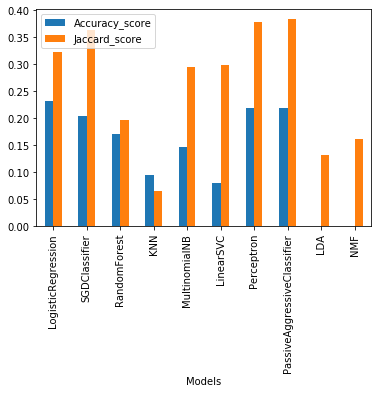

<Figure size 2160x1080 with 0 Axes>

In [46]:
score_AccuracyJaccard_df = pd.DataFrame({
    'Models': ['LogisticRegression', 'SGDClassifier',
               'RandomForest', 'KNN', 'MultinomialNB', 'LinearSVC',
               'Perceptron', 'PassiveAggressiveClassifier', 'LDA', 'NMF'],
    'Accuracy_score': [accuracy_score_logr,
                       accuracy_score_sgd,
                       accuracy_score_rand,
                       accuracy_score_knn,
                       accuracy_score_mnb,
                       accuracy_score_lsvc,
                       accuracy_score_prpt,
                       accuracy_score_pac,
                       0,
                       0],
    'Jaccard_score': [jaccard_score_logr,
                      jaccard_score_sgd,
                      jaccard_score_rand,
                      jaccard_score_knn,
                      jaccard_score_mnb,
                      jaccard_score_lsvc,
                      jaccard_score_prpt,
                      jaccard_score_pac,
                      jacard_score_LDA,
                      jacard_score_NMF]})
ax = plt.gca()
score_AccuracyJaccard_df.plot(kind='bar', x='Models',
                              y=['Accuracy_score', 'Jaccard_score'], ax=ax)
plt.figure(figsize=(30, 15))
plt.show()

###  Test sur formulaire :

On constate que le modèle de LogisticRegression a le meilleur score, donc nous allons tester notre prédiction à partir de ce modèle

In [47]:
# Sauvegarder le modèle sur le disque :
pickle.dump(sgd_linear_clf_fit, open('models/model.pkl', 'wb'))

#### Prediction avec LogisticRegression :

In [48]:
# Loading model to compare the results
model = pickle.load(open('models/model.pkl', 'rb'))
# model = log_reg_clf_fit
# textInput = data_preprocess[(data_preprocess['Id'] == 9)]['BodyTitle']
most_freq_words = top1000words_exp
most_freq_tags = top100tags_exp

4:80: E501 line too long (94 > 79 characters)


In [53]:
textInput = "je suis un developpeur de javascript et python et j'ai besoin d'aide pour un calcul de date"
print(textInput)

je suis un developpeur de javascript et python et j'ai besoin d'aide pour un calcul de date


1:80: E501 line too long (105 > 79 characters)


In [54]:
tagslist = predictTag(model, textInput, top1000words_exp, top100tags_exp)
print('les tags proposées sont : ', tagslist)

les tags proposées sont :  ['python', 'javascript', 'datetime']
